In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from time import time
import dill 
import random as rd

from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.naive_bayes import GaussianNB

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay

In [2]:
train = pd.read_csv('exoTrain.csv')
test = pd.read_csv('exoTest.csv')

train.iloc[:,0] = train.iloc[:,0]-1 #change labels to 0,1
test.iloc[:,0] = test.iloc[:,0]-1

## Pre-processed, no resampling

# Exploratory analysis

## Basic statistics

In [ ]:
means = train.iloc[:,1:].mean(axis=1)
std = train.iloc[:,1:].std(axis=1)

exo_mean = means[0:37]
exo_sd = std[0:37]

no_mean = means[37:]
no_sd = std[37:]

In [ ]:
fig = plt.figure(figsize=(13,5))
fig.suptitle('Mean fluxes for stars with and without confirmed exoplanets', fontsize=15)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(121)
ax.hist(exo_mean, bins=20)
ax.set_ylabel('Number of stars')
ax.set_xlabel('Mean flux (arbitrary units)')
ax.set_title('Histogram of mean flux values for star with confirmed exoplanets')
ax.grid()

ax = fig.add_subplot(122)
ax.hist(no_mean, bins=20)
ax.set_ylabel('Number of stars')
ax.set_xlabel('Mean flux (arbitrary units)')
ax.set_title('Histogram of mean flux values for star with no confirmed exoplanets')
ax.grid()

plt.show()

In [ ]:
plt.hist(exo_mean[exo_mean>-800], bins=5) #Star number 27 might be an outlier
plt.grid()
plt.show()

## Stars with exoplanet


In [ ]:
time_span = (75*24*60)/3197
x = np.arange(3197) * (time_span/60.0) 

In [ ]:
fig = plt.figure(figsize=(15,20))
fig.suptitle('Light curves of stars 1 to 20 with confirmed exoplanet in the training set', fontsize=20)
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(20):
    ax = fig.add_subplot(5,4,i+1)
    ax.set_title('Star {}'.format(i+1))
    ax.set_ylabel('Flux (arbitrary units)')
    ax.set_xlabel('Time ($h$)')
    ax.plot(x, train.iloc[i,1:])
    ax.grid()

plt.show()

fig = plt.figure(figsize=(15,20))
fig.suptitle('Light curves of stars 21 to 37 with confirmed exoplanet in the training set', fontsize=20)
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(20,37):
    ax = fig.add_subplot(5,4,i-19)
    ax.set_title('Star {}'.format(i+1))
    ax.set_ylabel('Flux (arbitrary units)')
    ax.set_xlabel('Time ($h$)')
    ax.plot(x, train.iloc[i,1:])
    ax.grid()

plt.show()

### Closer view of some of them

In [ ]:
fig = plt.figure(figsize=(15,10))
fig.suptitle('Light curves of stars 8, 12, 13 and 37 with confirmed exoplanet', fontsize=20)
fig.subplots_adjust(hspace=0.4, wspace=0.4)
index = [7,11,12,30]
for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    ax.set_title('Star {}'.format(index[i]+1))
    ax.set_ylabel('Flux (arbitrary units)')
    ax.set_xlabel('Time ($h$)')
    ax.plot(x, train.iloc[index[i],1:])
    ax.grid()

plt.show()

print([means[i] for i in index])
print([std[i] for i in index])

## Stars w/o exoplanet

In [ ]:
fig = plt.figure(figsize=(15,20))
fig.suptitle('Light curves of 20 random stars without confirmed exoplanet in the training set', fontsize=20)
fig.subplots_adjust(hspace=0.4, wspace=0.4)
rd.seed(12345)
index = rd.sample(range(37,5087), 20)
for i in range(20):
    ax = fig.add_subplot(5,4,i+1)
    ax.set_title('Star {}'.format(index[i]+1))
    ax.set_ylabel('Flux (arbitrary units)')
    ax.set_xlabel('Time ($h$)')
    ax.plot(x, train.iloc[index[i],1:])
    ax.grid()

plt.show()

# Pre-processing

## Star 12

In [ ]:
def norm(x):
    return (x-np.mean(x)) / np.std(x)

def smoothing(x):
    return sp.ndimage.filters.gaussian_filter(x, sigma=5)

In [ ]:
smoothed = smoothing(train.iloc[11,1:])
detrended = train.iloc[11,1:]-smoothed
stand = norm(detrended)

fig = plt.figure(figsize=(15,10))
fig.suptitle('Pre-processing of Star 12 with confirmed exoplanet', fontsize=20)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(221)
ax.set_title('Original light curve')
ax.set_ylabel('Flux (arbitrary units)')
ax.set_xlabel('Time ($h$)')
ax.plot(x, train.iloc[11,1:])
ax.grid()

ax = fig.add_subplot(222)
ax.set_title('Smoothed light curve')
ax.set_ylabel('Flux (arbitrary units)')
ax.set_xlabel('Time ($h$)')
ax.plot(x, smoothed)
ax.grid()

ax = fig.add_subplot(223)
ax.set_title('Detrended light curve')
ax.set_ylabel('Flux (arbitrary units)')
ax.set_xlabel('Time ($h$)')
ax.plot(x, detrended)
ax.grid()

ax = fig.add_subplot(224)
ax.set_title('Standardized light curve')
ax.set_ylabel('Flux (arbitrary units)')
ax.set_xlabel('Time ($h$)')
ax.plot(x, stand)
ax.grid()

plt.show()

## Pre-processing function

In [3]:
def preprocessing(x):
    smooth = sp.ndimage.filters.gaussian_filter(x, sigma=5)
    detrend = x- smooth
    scale = (detrend-np.mean(detrend)) / np.std(detrend)
    return scale

# Test models


## Resampled, no pre-processing

In [ ]:
# define pipeline
over = RandomOverSampler()
under = RandomUnderSampler()
steps = [('o', over), ('u', under), ('knn', KNeighborsClassifier())]
clf = Pipeline(steps=steps)

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)

param_grid={'o__sampling_strategy' : list(linspace(0.1,0.3,3)), 'u__sampling_strategy' : list(linspace(0.3,0.6,3)), 'knn__n_neighbors' : list(range(1,6,2))}

clf = GridSearchCV(clf,
param_grid,
scoring='recall',
cv=cv , n_jobs=-1, verbose=1)

# evaluate pipeline
np.random.seed(12345)
clf=clf.fit(x_train,y_train)
#predictions
pred = clf.predict(x_test)

RocCurveDisplay.from_predictions(y_test, pred)
plt.title("ROC - AUC", fontsize=15)

plt.show()
RocCurveDisplay.from_estimator(clf, x_test, y_test)
plt.title("ROC - AUC", fontsize=15)
plt.show()

sns.heatmap(confusion_matrix(y_test,pred), annot = True, cmap = "BuPu", fmt = "d", linecolor = "k")
plt.title("Confusion Matrix", fontsize=15)
plt.show()

print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))
print(clf.best_params_)

## Resampled, Pre-processed with fft.

In [ ]:
train.iloc[:,1:] = train.iloc[:,1:].apply(norm, axis=1)
test.iloc[:,1:] = test.iloc[:,1:].apply(norm, axis=1)

x_train = train.drop(["LABEL"], axis=1)
y_train = train["LABEL"]   
x_test = test.drop(["LABEL"], axis=1)
y_test = test["LABEL"]

from numpy.fft import rfft
x_fft =np.empty([5087,1599], dtype=complex)
for i in range(x_train.shape[0]):
    x_fft[i,:] = rfft(x_train.iloc[i,:])

x_fft=abs(x_fft)

x_fft_test =np.empty([570,1599])
for i in range(x_test.shape[0]):
    x_fft_test[i,:] = abs(rfft(x_test.iloc[i,:]))

In [ ]:
# define pipeline
over = RandomOverSampler()
under = RandomUnderSampler()
steps = [('o', over), ('u', under), ('knn', KNeighborsClassifier())]
clf = Pipeline(steps=steps)

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)

param_grid={'o__sampling_strategy' : list(linspace(0.1,0.3,3)), 'u__sampling_strategy' : list(linspace(0.3,0.6,3)), 'knn__n_neighbors' : list(range(1,6,2))}

clf = GridSearchCV(clf,
param_grid,
scoring='recall',
cv=cv , n_jobs=-1, verbose=1)

# evaluate pipeline
np.random.seed(12345)
clf=clf.fit(x_fft,y_train)
#predictions
pred = clf.predict(x_fft_test)

RocCurveDisplay.from_predictions(y_test, pred)
plt.title("ROC - AUC", fontsize=15)

plt.show()
RocCurveDisplay.from_estimator(clf, x_fft_test, y_test)
plt.title("ROC - AUC", fontsize=15)
plt.show()

sns.heatmap(confusion_matrix(y_test,pred), annot = True, cmap = "BuPu", fmt = "d", linecolor = "k")
plt.title("Confusion Matrix", fontsize=15)
plt.show()

print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))
print(clf.best_params_)

## Pre-processed, no resampling.

In [4]:
train = pd.read_csv('exoTrain.csv')
test = pd.read_csv('exoTest.csv')

train.iloc[:,0] = train.iloc[:,0]-1 #change labels to 0,1
test.iloc[:,0] = test.iloc[:,0]-1

train.iloc[:,1:] = train.iloc[:,1:].apply(preprocessing, axis=1)
test.iloc[:,1:] = test.iloc[:,1:].apply(preprocessing, axis=1)

x_train = train.drop(["LABEL"], axis=1)
y_train = train["LABEL"]   
x_test = test.drop(["LABEL"], axis=1)
y_test = test["LABEL"]

Fitting 9 folds for each of 3 candidates, totalling 27 fits


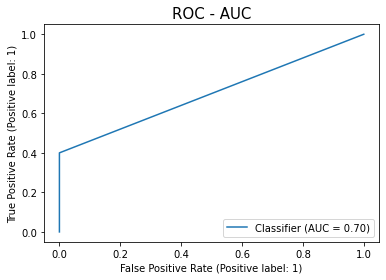

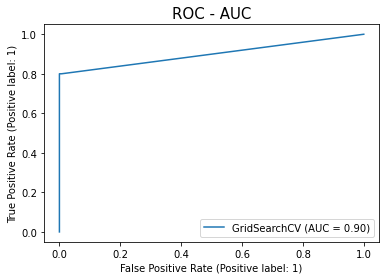

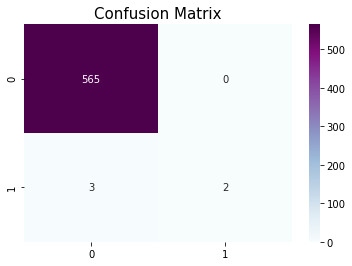

[[565   0]
 [  3   2]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       1.00      0.40      0.57         5

    accuracy                           0.99       570
   macro avg       1.00      0.70      0.78       570
weighted avg       0.99      0.99      0.99       570

{'n_neighbors': 5}


In [2]:
clf = KNeighborsClassifier()

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)

param_grid={'n_neighbors' : list(range(1,6,2))}

clf = GridSearchCV(clf,
param_grid,
scoring='roc_auc',
cv=cv , n_jobs=-1, verbose=1)

# evaluate pipeline
np.random.seed(12345)
clf=clf.fit(x_train,y_train)
#predictions
pred = clf.predict(x_test)

RocCurveDisplay.from_predictions(y_test, pred)
plt.title("ROC - AUC", fontsize=15)

plt.show()
RocCurveDisplay.from_estimator(clf, x_test, y_test)
plt.title("ROC - AUC", fontsize=15)
plt.show()

sns.heatmap(confusion_matrix(y_test,pred), annot = True, cmap = "BuPu", fmt = "d", linecolor = "k")
plt.title("Confusion Matrix", fontsize=15)
plt.show()

print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))
print(clf.best_params_)


# Evaluation

In [5]:
def evaluator(over, model, param_grid, refit, n_iter=25):
    t=time()

    steps = [('over', over), ('under', RandomUnderSampler()), ('model', model)]
    clf = Pipeline(steps=steps)

    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    clf = RandomizedSearchCV(clf, param_grid, scoring=['roc_auc', 'recall', 'f1'], cv=cv , n_jobs=-1, verbose=1, refit=refit, n_iter=n_iter)
    
    np.random.seed(12345)
    clf=clf.fit(x_train,y_train)
    total=time()-t
    
    print('\n')
    print('Resampling with {}'.format(str(over)+' for a model: '+str(model)+' and ' + str(refit)+' as the metric to refit.'),
          '\n\n') 
    print('It took {0:.4g} seconds to tune and train the model. \n\n'.format(total))
    
    best_params = clf.best_params_
    print('Best Parameters: \n', best_params, '\n\n')
    
    pred = clf.predict(x_test)
    c_matrix = confusion_matrix(y_test,pred)
    clf_report = classification_report(y_test,pred)
    
    print('Confusion Matrix: \n', c_matrix, '\n')
    print('Classification report: \n', clf_report, '\n')
    
    sns.heatmap(c_matrix, annot = True, cmap = "BuPu", fmt = "d", linecolor = "k")
    plt.title("Confusion Matrix", fontsize=15)
    plt.show()

    RocCurveDisplay.from_predictions(y_test, pred)
    plt.title("ROC - AUC", fontsize=15)
    plt.show()
    
    RocCurveDisplay.from_estimator(clf, x_test, y_test)
    plt.title("ROC - AUC", fontsize=15)
    plt.show()
    
    columns = ['mean_fit_time','mean_test_recall', 'rank_test_recall', 'mean_test_f1', 
               'rank_test_f1','mean_test_roc_auc','rank_test_roc_auc']
    params=list()
    for key in param_grid:
        params.append('_'.join(['param', key]))
    cols = columns + params
    sort_by='_'.join(['rank_test',refit])
    cv_res = pd.DataFrame(clf.cv_results_).sort_values(by=sort_by).reset_index().loc[:,cols]
    
    print('Evaluation metrics: \n')
    print(cv_res.head(), '\n ------------------------------------------------------- \n\n')
    
    return clf, pred, total, best_params, c_matrix, clf_report, cv_res

## Models

* Gaussian Naive Bayes
* K-Nearest Neighbors
* Support Vector Machine:
    * SVMLinear
    * SVM rbf (Radial basis function)
    * SVM Poly (degree: 2- 4)
* Decision trees
* Ensemble methods:
    * Random Forest
    * Gradient Boosting
    * AdaBoost

In [7]:
#dual=False porque n_samples>n_features en SVCLinear ---- , LinearSVC(dual=False)
models =[GaussianNB(), KNeighborsClassifier(), SVC(kernel='linear'), SVC(kernel='poly'), SVC(kernel='rbf'), DecisionTreeClassifier(), RandomForestClassifier(), 
         GradientBoostingClassifier(), AdaBoostClassifier()]

grid_GNB = {'over__sampling_strategy' : list(np.linspace(0.1,0.5,5)), 'under__sampling_strategy' : list(np.linspace(0.5,0.9,5))}

grid_KNN = {'over__sampling_strategy' : list(np.linspace(0.1,0.5,5)), 'under__sampling_strategy' : list(np.linspace(0.5,0.9,5)),
            'model__n_neighbors' : list(range(1,8,2))} 

grid_SVCL = {'over__sampling_strategy' : list(np.linspace(0.1,0.5,5)), 'under__sampling_strategy' : list(np.linspace(0.5,0.9,5)),
             'model__C' : [0.1,1,5,10,100,1000]}

grid_SVCP = {'over__sampling_strategy' : list(np.linspace(0.1,0.5,5)), 'under__sampling_strategy' : list(np.linspace(0.5,0.9,5)),
            'model__C' : [0.1,1,5,10,100,1000], 'model__degree' : [2,3,4]}

grid_SVCR = {'over__sampling_strategy' : list(np.linspace(0.1,0.5,5)), 'under__sampling_strategy' : list(np.linspace(0.5,0.9,5)),
            'model__C' : [0.1,1,5,10,100,1000]}

#grid_SVL = {'over__sampling_strategy' : list(np.linspace(0.1,0.5,5)), 'under__sampling_strategy' : list(np.linspace(0.5,0.9,5)),
           # 'model__C' : list(np.linspace(1,2,4))}

grid_tree = {'over__sampling_strategy' : list(np.linspace(0.1,0.5,5)), 'under__sampling_strategy' : list(np.linspace(0.5,0.9,5)),
            'model__criterion' : ['gini', 'entropy'], 'model__max_depth' : list(range(6,31,2))}

grid_RF = {'over__sampling_strategy' : list(np.linspace(0.1,0.5,5)), 'under__sampling_strategy' : list(np.linspace(0.5,0.9,5)),
           'model__criterion' : ['gini', 'entropy'], 'model__n_estimators' : list(range(50,201,50)),
           'model__max_depth' : list(range(6,31,2)), 'model__max_features' : ['sqrt', 'log2']}

grid_GB = {'over__sampling_strategy' : list(np.linspace(0.1,0.5,5)), 'under__sampling_strategy' : list(np.linspace(0.5,0.9,5)),
            'model__n_estimators' : list(range(50,201,50)), 'model__max_depth' : list(range(2,21,2)), 
            'model__learning_rate' : [0.01,0.1,0.2,0.3,0.5]}

grid_ada = {'over__sampling_strategy' : list(np.linspace(0.1,0.5,5)), 'under__sampling_strategy' : list(np.linspace(0.5,0.9,5)),
            'model__n_estimators' : list(range(50,151,50)),'model__learning_rate' : [0.01,0.1,0.2,0.3,0.5]}

param_grids = [grid_GNB, grid_KNN, grid_SVCL, grid_SVCP, grid_SVCR, grid_tree, grid_RF, grid_GB, grid_ada]

## Evaluation time!

Fitting 15 folds for each of 25 candidates, totalling 375 fits


Resampling with RandomOverSampler() for a model: GaussianNB() and roc_auc as the metric to refit. 


It took 215.8 seconds to tune and train the model. 


Best Parameters: 
 {'under__sampling_strategy': 0.8, 'over__sampling_strategy': 0.1} 


Confusion Matrix: 
 [[523  42]
 [  3   2]] 

Classification report: 
               precision    recall  f1-score   support

           0       0.99      0.93      0.96       565
           1       0.05      0.40      0.08         5

    accuracy                           0.92       570
   macro avg       0.52      0.66      0.52       570
weighted avg       0.99      0.92      0.95       570
 



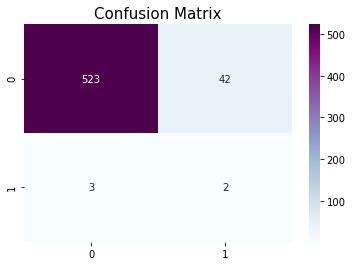

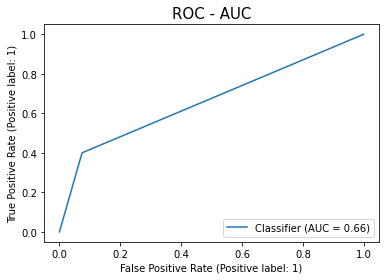

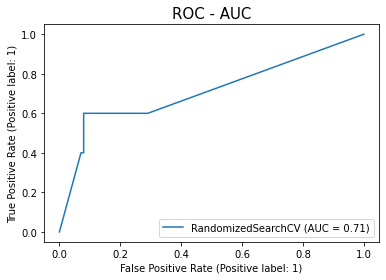

Evaluation metrics: 

   mean_fit_time  mean_test_recall  rank_test_recall  mean_test_f1  \
0       4.925565          0.595238                 2      0.108811   
1       5.007520          0.611905                 1      0.108397   
2       4.735612          0.584524                 4      0.111624   
3       5.344271          0.594048                 3      0.114942   
4       5.395919          0.576190                 5      0.112384   

   rank_test_f1  mean_test_roc_auc  rank_test_roc_auc  \
0            24           0.864827                  1   
1            25           0.860775                  2   
2            22           0.860555                  3   
3            16           0.848444                  4   
4            21           0.844658                  5   

  param_over__sampling_strategy param_under__sampling_strategy  
0                           0.1                            0.8  
1                           0.1                            0.9  
2                  

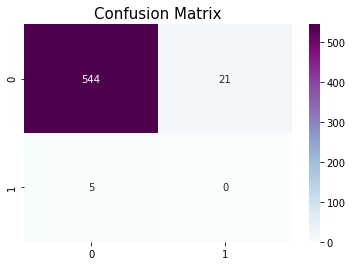

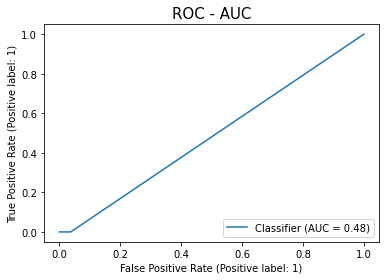

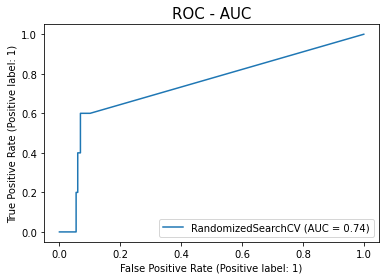

Evaluation metrics: 

   mean_fit_time  mean_test_recall  rank_test_recall  mean_test_f1  \
0       6.365169          0.336905                 7      0.119576   
1       4.728082          0.388095                 1      0.127955   
2       5.113722          0.354762                 2      0.119131   
3       4.844303          0.353571                 4      0.116426   
4       6.409145          0.327381                10      0.120935   

   rank_test_f1  mean_test_roc_auc  rank_test_roc_auc  \
0            21           0.776717                  1   
1             5           0.776649                  2   
2            22           0.776259                  3   
3            24           0.775989                  4   
4            20           0.772481                  5   

  param_over__sampling_strategy param_under__sampling_strategy  
0                           0.2                            0.9  
1                           0.1                            0.9  
2                  

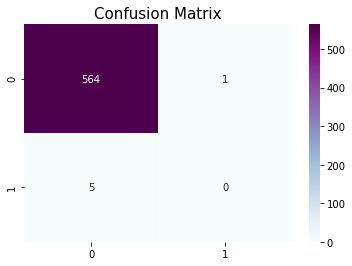

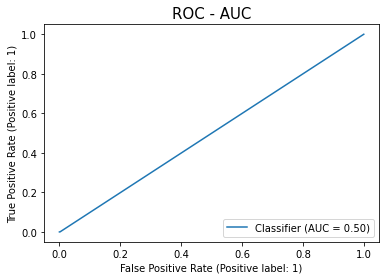

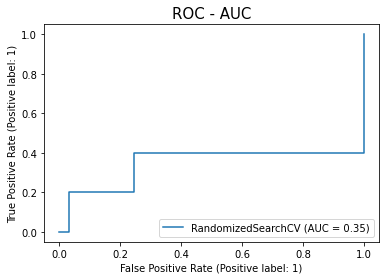

Evaluation metrics: 

   mean_fit_time  mean_test_recall  rank_test_recall  mean_test_f1  \
0       6.215085          0.272619                 2      0.396263   
1       6.140735          0.280952                 1      0.411852   
2      10.576314          0.263095                 6      0.389192   
3      10.435333          0.271429                 3      0.398889   
4      11.738663          0.263095                 6      0.392222   

   rank_test_f1  mean_test_roc_auc  rank_test_roc_auc  \
0             4           0.718194                  1   
1             1           0.716512                  2   
2             9           0.716388                  3   
3             3           0.715708                  4   
4             5           0.714321                  5   

  param_over__sampling_strategy param_under__sampling_strategy  
0                           0.1                            0.9  
1                           0.1                            0.8  
2                  

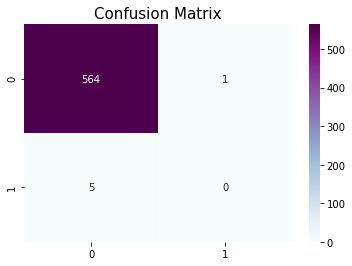

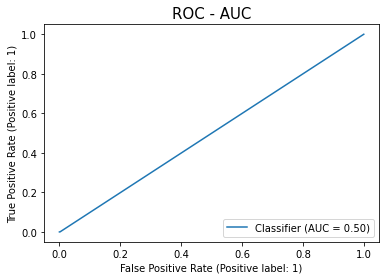

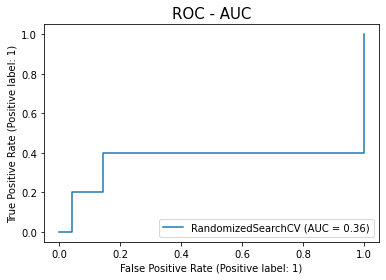

Evaluation metrics: 

   mean_fit_time  mean_test_recall  rank_test_recall  mean_test_f1  \
0       6.458823          0.280952                 5      0.415556   
1      18.063528          0.272619                 7      0.405859   
2       9.698596          0.289286                 1      0.423248   
3      17.201823          0.263095                15      0.389192   
4      17.220990          0.254762                23      0.377340   

   rank_test_f1  mean_test_roc_auc  rank_test_roc_auc  \
0             3           0.714806                  1   
1             7           0.713873                  2   
2             1           0.712860                  3   
3            16           0.712854                  4   
4            24           0.712725                  5   

  param_over__sampling_strategy param_under__sampling_strategy  
0                           0.1                            0.8  
1                           0.4                            0.9  
2                  

In [8]:
over = list()
smote = list()

time0 = time()

for i in range(len(models)):
    over.append(evaluator(RandomOverSampler(), models[i], param_grids[i], refit='roc_auc'))
    smote.append(evaluator(SMOTE(), models[i], param_grids[i], refit='roc_auc')  )
    filepath = '_'.join(['session', str(i), str(models[i]),'.pkl'])
    dill.dump_session(filepath) # Save the session in each iteration
    
    
time1 = time() - time0
print('Total time consumed by all the models: {}'.format(time1), 'seconds.')

# Results Analysis

## Finding best tuned parameters according to other metrics

In [ ]:
def best_params(res, model, param_grid):
    n = len(param_grid)
    f1 = res[6].iloc[:,[0,2,4,6] +list(range(len(res[6].columns)-n,len(res[6].columns)))].sort_values(by='rank_test_f1').reset_index()
    recall = res[6].iloc[:,[0,2,4,6] +list(range(len(res[6].columns)-n,len(res[6].columns)))].sort_values(by='rank_test_recall').reset_index()
    
    f1_bp= dict(f1.iloc[0,list(range(len(f1.columns)-n,len(f1.columns)))])
    recall_bp= dict(recall.iloc[0,list(range(len(recall.columns)-n,len(recall.columns)))])
    return f1, recall, f1_bp, recall_bp

This will evaluate other hyper parameter combinations if needed

In [4]:
def evaluator_2(steps):   
    clf = Pipeline(steps=steps)
    
    np.random.seed(12345)
    clf=clf.fit(x_train,y_train)
    
    pred = clf.predict(x_test)
    c_matrix = confusion_matrix(y_test,pred)
    clf_report = classification_report(y_test,pred)
    
    print('Confusion Matrix: \n', c_matrix, '\n')
    print('Classification report: \n', clf_report, '\n')
    
    sns.heatmap(c_matrix, annot = True, cmap = "BuPu", fmt = "d", linecolor = "k")
    plt.title("Confusion Matrix", fontsize=15)
    plt.show()

    RocCurveDisplay.from_predictions(y_test, pred)
    plt.title("ROC - AUC", fontsize=15)
    plt.show()
    
    RocCurveDisplay.from_estimator(clf, x_test, y_test)
    plt.title("ROC - AUC", fontsize=15)
    plt.show()
    
    return clf

In [ ]:
for i in range(len(models)):
    print('OVERSAMPLING + '+str(models[i]) + '\n')
    f1, recall, f1_bp, recall_bp = best_params(over[i], models[i], param_grids[i])
    print('F1 \n', f1_bp, '\n')
    print('Recall \n', recall_bp, '\n')
    
    print('SMOTE + '+str(models[i]) + '\n')
    f1, recall, f1_bp, recall_bp = best_params(smote[i], models[i], param_grids[i])
    print('F1 \n', f1_bp, '\n')
    print('Recall \n', recall_bp, '\n')
   

In [ ]:
over=0.5
under=0.5
model=GaussianNB()

steps = [('over', RandomOverSampler(sampling_strategy=over)), ('under', RandomUnderSampler(sampling_strategy=under)), ('model', model)]

o = evaluator_2(steps)

steps = [('over', SMOTE(sampling_strategy=over)), ('under', RandomUnderSampler(sampling_strategy=under)), ('model', model)]

s=evaluator_2(steps)

Let´s see if we can improve KNN 

Confusion Matrix: 
 [[562   3]
 [  1   4]] 

Classification report: 
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       565
           1       0.57      0.80      0.67         5

    accuracy                           0.99       570
   macro avg       0.78      0.90      0.83       570
weighted avg       0.99      0.99      0.99       570
 



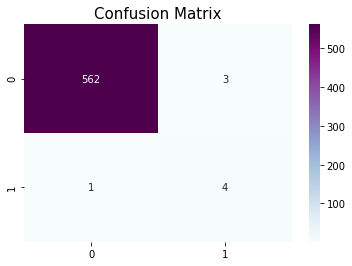

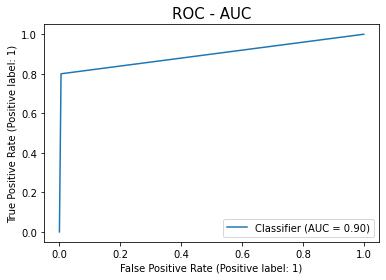

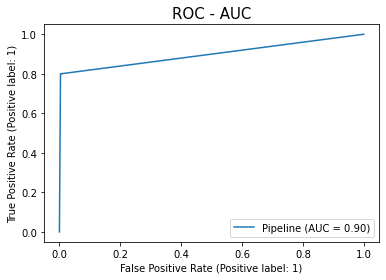

Confusion Matrix: 
 [[437 128]
 [  0   5]] 

Classification report: 
               precision    recall  f1-score   support

           0       1.00      0.77      0.87       565
           1       0.04      1.00      0.07         5

    accuracy                           0.78       570
   macro avg       0.52      0.89      0.47       570
weighted avg       0.99      0.78      0.87       570
 



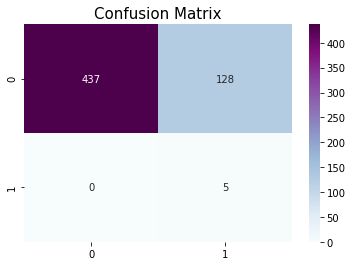

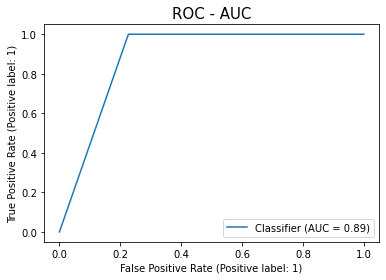

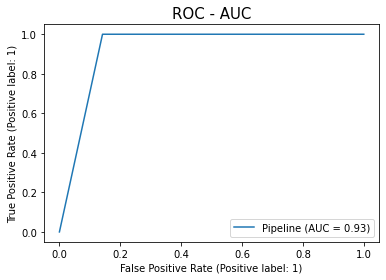

In [5]:
over=0.5
under=0.7
model=KNeighborsClassifier(n_neighbors=3)

steps = [('over', RandomOverSampler(sampling_strategy=over)), ('under', RandomUnderSampler(sampling_strategy=under)), ('model', model)]

o = evaluator_2(steps)

steps = [('over', SMOTE(sampling_strategy=over)), ('under', RandomUnderSampler(sampling_strategy=under)), ('model', model)]

s=evaluator_2(steps)

This is the **best model** so far: 
* over=0.5
* under=0.7
* model=KNeighborsClassifier(n_neighbors=3)

with RandomOverSampler.

Let´s try the rest of them.

In [ ]:
model =SVC(kernel='linear', C=100)
over=0.1
under=0.9

steps = [('over', RandomOverSampler(sampling_strategy=over)), ('under', RandomUnderSampler(sampling_strategy=under)), ('model', model)]

o = evaluator_2(steps)

model =SVC(kernel='linear', C=1000)
over=0.2
under=0.9

steps = [('over', SMOTE(sampling_strategy=over)), ('under', RandomUnderSampler(sampling_strategy=under)), ('model', model)]

s=evaluator_2(steps)

###########################################

model =SVC(kernel='poly', C=1000, degree=2)
over=0.1
under=0.9

steps = [('over', RandomOverSampler(sampling_strategy=over)), ('under', RandomUnderSampler(sampling_strategy=under)), ('model', model)]

o = evaluator_2(steps)


#############################################

model =SVC(kernel='rbf', C=1000)
over=0.1
under=0.8

steps = [('over', SMOTE(sampling_strategy=over)), ('under', RandomUnderSampler(sampling_strategy=under)), ('model', model)]

s=evaluator_2(steps)

###############################################

model =DecisionTreeClassifier(criterion='gini', max_depth=28)
over=0.2
under=.6

steps = [('over', RandomOverSampler(sampling_strategy=over)), ('under', RandomUnderSampler(sampling_strategy=under)), ('model', model)]

o = evaluator_2(steps)

model =DecisionTreeClassifier(criterion='gini', max_depth=22)
over=0.5
under=0.5

steps = [('over', SMOTE(sampling_strategy=over)), ('under', RandomUnderSampler(sampling_strategy=under)), ('model', model)]

s=evaluator_2(steps)

#####################################################

model =RandomForestClassifier(criterion='entropy', n_estimators=100, max_depth=14,max_features='sqrt')
over=0.1
under=0.9

steps = [('over', RandomOverSampler(sampling_strategy=over)), ('under', RandomUnderSampler(sampling_strategy=under)), ('model', model)]

o = evaluator_2(steps)

############################################################

model =GradientBoostingClassifier(n_estimators=200, max_depth=2, learning_rate=0.5)
over=0.4
under=0.9

steps = [('over', RandomOverSampler(sampling_strategy=over)), ('under', RandomUnderSampler(sampling_strategy=under)), ('model', model)]

o = evaluator_2(steps)

model =GradientBoostingClassifier(n_estimators=150, max_depth=2, learning_rate=0.1)
over=0.1
under=0.8

steps = [('over', SMOTE(sampling_strategy=over)), ('under', RandomUnderSampler(sampling_strategy=under)), ('model', model)]

s=evaluator_2(steps)

#######################################################

model =AdaBoostClassifier(n_estimators=150, learning_rate=0.5)
over=0.3
under=0.8

steps = [('over', RandomOverSampler(sampling_strategy=over)), ('under', RandomUnderSampler(sampling_strategy=under)), ('model', model)]

o = evaluator_2(steps)

model =AdaBoostClassifier(n_estimators=100, learning_rate=0.5)
over=0.5
under=0.5

steps = [('over', SMOTE(sampling_strategy=over)), ('under', RandomUnderSampler(sampling_strategy=under)), ('model', model)]

s=evaluator_2(steps)

